# Subsampling examples

In [1]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint
from scipy.ndimage.filters import uniform_filter1d

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [3]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
from algorithms.uniform_subsampler import *
from algorithms.queries import *

## Synthetic data

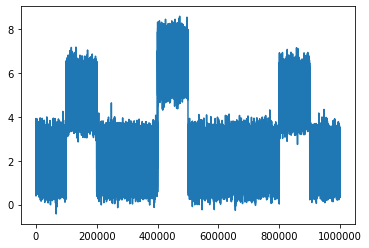

In [23]:
#Piecewise Stationary series

#Parameters
n = 1000000
mu = 2
sigma = 0.5

#Gaussian distribution
np.random.seed(100)
x = np.random.normal(mu, sigma, n)

#Altered means
x[100000:200000] += 3
x[400000:500000] += 4.5
x[600000:700000] += 0
x[800000:900000] += 3

#plot
plt.plot(x)

In [24]:
# Real average for comparison

real_average = np.random.normal(mu, 0, n)
real_average[100000:200000] += 3
real_average[400000:500000] += 4.5
real_average[600000:700000] += 0
real_average[800000:900000] += 3

In [19]:
uniform_sample = uniform_sampler(x, 10)
#uniform_moving_average = uniform_filter1d(uniform_sample, size = 1000)

In [20]:
uniform_mean = np.full(1000000,np.mean(uniform_sample))

In [28]:
# Using empirical Bernstein subsampler
eb_sample = empirical_bernstein(0.05,0.01,2.5,x)

#calculating the mean
subsample_eb_mean = np.full(1000000,np.mean(eb_sample))

breakpoint started
subsampler started
Interval size:  53035
Relative sample size:  1.66 %
----*----
Interval size:  33136
Relative sample size:  2.6 %
----*----
Interval size:  13829
Relative sample size:  6.36 %
----*----
Interval size:  5420
Relative sample size:  5.54 %
----*----
Interval size:  2214
Relative sample size:  13.55 %
----*----
Interval size:  62434
Relative sample size:  0.46 %
----*----
Interval size:  29934
Relative sample size:  1.0 %
----*----
Interval size:  48263
Relative sample size:  1.82 %
----*----
Block size greater than data interval
----*----
Interval size:  1554
Relative sample size:  59.2 %
----*----
Interval size:  2375
Relative sample size:  37.05 %
----*----
Interval size:  43159
Relative sample size:  2.04 %
----*----
Interval size:  104646
Relative sample size:  0.86 %
----*----
Interval size:  40942
Relative sample size:  0.56 %
----*----
Interval size:  41012
Relative sample size:  0.56 %
----*----
Interval size:  18046
Relative sample size:  1.22

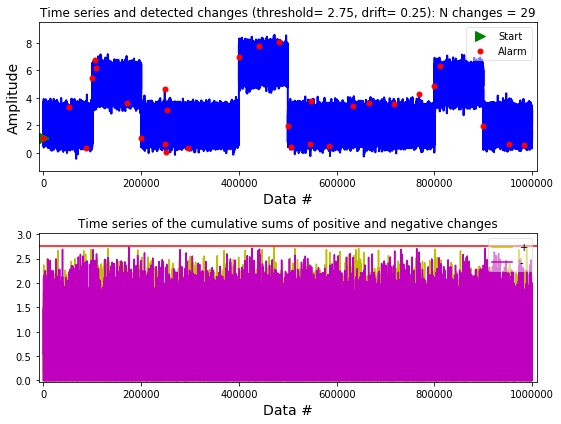

In [36]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue, 2.75, .25, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,2.5,10,x, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

In [37]:
threshold_data = return_queue.get()

while return_queue.empty() == False:
    sub = return_queue.get()
    threshold_data = np.concatenate((threshold_data, sub), axis = None)

In [38]:
#Threshold evaluation
threshold_real_value = threshold_query(x, 8)
print('Real number of values above threshold: ', len(threshold_real_value))
threshold_uniform_sampler = threshold_query(uniform_sample, 8)
print('Values above threshold for uniform sampling: ', len(threshold_uniform_sampler))
threshold_eb_sampler = threshold_query(eb_sample, 8)
print('Values above threshold for EB sampling: ', len(threshold_eb_sampler))
threshold_otss = threshold_query(threshold_data, 8)
print('Values above threshold for OTSS: ', len(threshold_otss))

Real number of values above threshold:  120
Values above threshold for uniform sampling:  7
Values above threshold for EB sampling:  0
Values above threshold for OTSS:  1


In [10]:
# Calculating statistics
sub, rel_size = subsample_analysis(return_queue, index_queue)

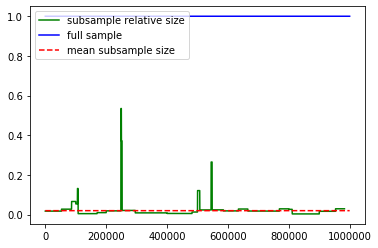

In [13]:
# Plotting subsample size
plt.plot(rel_size, color = 'green')
plt.plot(np.full(1000000,1), color = 'blue')
plt.plot(np.full(1000000,np.mean(rel_size)), color='red', linestyle ='--' )
plt.legend(['subsample relative size', 'full sample', 'mean subsample size'], loc='upper left')

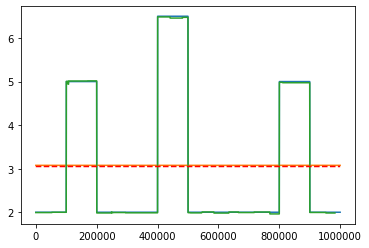

In [20]:
#plotting mean

plt.plot(real_average)
plt.plot(subsample_eb_mean)
plt.plot(sub)
plt.plot(uniform_mean, color = 'red', linestyle ='--')

## Real Data

### Example 1 - UCI Household power consumption
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [4]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/household_power_consumption.txt'
data = pd.read_csv(path, sep = ';')

#### Exploratory data analysis and data cleaning


In [5]:
print(data.head(5))

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [7]:
data = data[data.Sub_metering_1 != '?']
data = data[data.Sub_metering_2 != '?']
data = data[data.Sub_metering_3 != '?']

In [8]:
data.index = pd.to_datetime(data['Date'] +' '+ data['Time'])
data_clean = data.drop(columns = ['Date', 'Time'])

In [9]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 125.1+ MB


#### Sub metering 3

In [10]:
x = data_clean['Sub_metering_3']
x = x['2007-01':'2008-12']

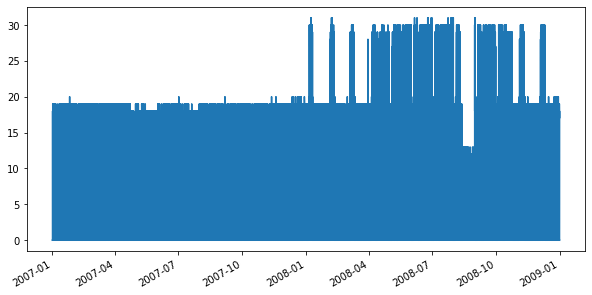

In [14]:
plt.figure(figsize=(10,5))
x.plot()

In [ ]:
#breakpoint detection Threshold = 5, drift = 17.5

queue_energy = mp.Queue()
return_queue_energy = mp.Queue()
index_queue_energy = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue_energy, 5, 12.5, False, False))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,15,10,x, queue_energy, return_queue_energy, index_queue_energy, 1000))

p1.start()
p2.start()

In [16]:
sub_energy, rel_size_energy = subsample_analysis(return_queue_energy, index_queue_energy)

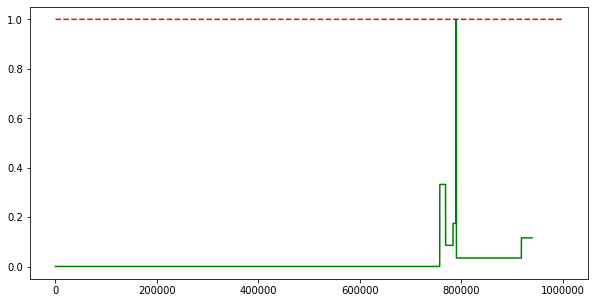

In [18]:
# Plotting subsample size
plt.figure(figsize=(10,5))
plt.plot(rel_size_energy, color = 'green')
#plt.plot(np.full(2000000,1), color = 'blue')
plt.plot(np.full(1000000,max(rel_size_energy)), color='red', linestyle ='--' )
#plt.legend(['subsample relative size', 'full sample', 'maximum subsample size'], loc='upper left')

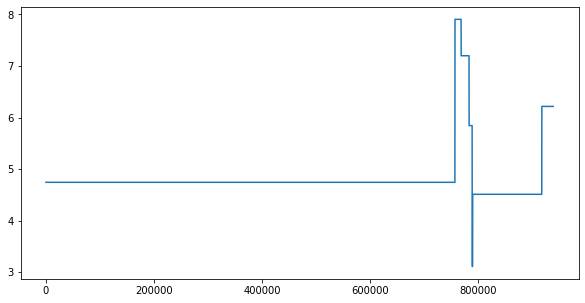

In [19]:
#plotting mean
plt.figure(figsize=(10,5))
#plt.plot(real_average)
#plt.plot(subsample_eb_mean)
plt.plot(sub_energy)

#### Voltage

In [20]:
y = data_clean['Voltage']
y = y.astype('float')
y = y['2007-01':'2008-12']

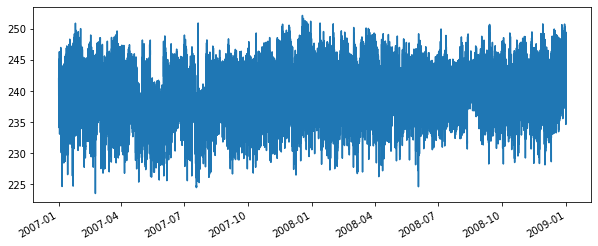

In [21]:
plt.figure(figsize=(10,4))
y.plot()

In [ ]:
#breakpoint detection Threshold = 5, drift = 17.5

queue_voltage = mp.Queue()
return_queue_voltage = mp.Queue()
index_queue_voltage = mp.Queue()
p1 = mp.Process(target = detection, args = (y, queue_voltage, 5, 1, False, False))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,20,10,x, queue_voltage, return_queue_voltage, index_queue_voltage, 1000))

p1.start()
p2.start()

In [23]:
sub_voltage, rel_size_voltage = subsample_analysis(return_queue_voltage, index_queue_voltage)

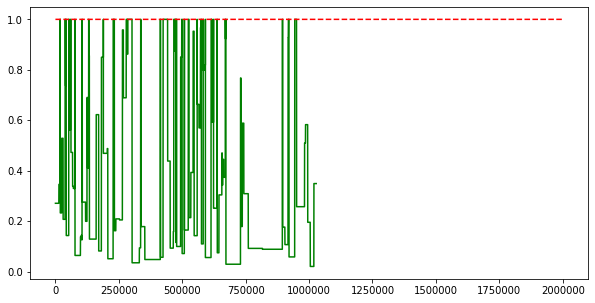

In [25]:
# Plotting subsample size
plt.figure(figsize=(10,5))
plt.plot(rel_size_voltage, color = 'green')
#plt.plot(np.full(2000000,1), color = 'blue')
plt.plot(np.full(2000000,max(rel_size_voltage)), color='red', linestyle ='--' )
#plt.legend(['subsample relative size', 'full sample', 'maximum subsample size'], loc='upper left')

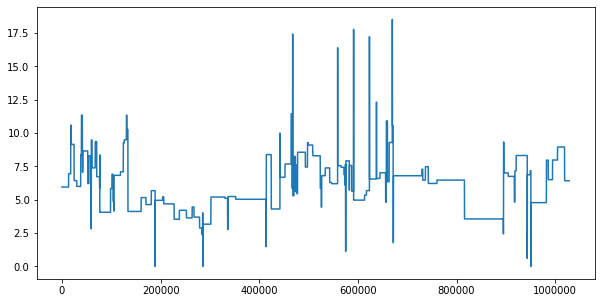

In [26]:
#plotting mean
plt.figure(figsize=(10,5))
#plt.plot(real_average)
#plt.plot(subsample_eb_mean)
plt.plot(sub_voltage)

### Querry analysis

In [10]:
x = data_clean['Sub_metering_3']
x = x['2007-01':'2008-12']

series_1 = x['2007-01':'2007-02']
series_2 = x['2007-04':'2007-05']
series_3 = x['2008-07':'2008-09']
series_4 = x['2008-02':'2007-05']
series_5 = x['2007-01':'2007-02']
series_6 = x[150:3000]
series_7 = x[250:5000]
series_8 = x[5000:60000]

In [11]:
full_series = pd.concat([series_6,series_7,series_8])
series = pd.concat([series_6,series_8])

In [12]:
full_series

2007-01-01 02:30:00    0.0
2007-01-01 02:31:00    0.0
2007-01-01 02:32:00    0.0
2007-01-01 02:33:00    0.0
2007-01-01 02:34:00    0.0
                      ... 
2007-11-02 15:57:00    0.0
2007-11-02 15:58:00    0.0
2007-11-02 15:59:00    0.0
2007-11-02 16:00:00    0.0
2007-11-02 16:01:00    0.0
Name: Sub_metering_3, Length: 62600, dtype: float64

In [13]:
print(full_series['2007-03'])

2007-03-01 00:00:00     0.0
2007-03-01 00:01:00     0.0
2007-03-01 00:02:00     0.0
2007-03-01 00:03:00     0.0
2007-03-01 00:04:00     0.0
                       ... 
2007-03-02 23:55:00    18.0
2007-03-02 23:56:00    18.0
2007-03-02 23:57:00    18.0
2007-03-02 23:58:00    17.0
2007-03-02 23:59:00    18.0
Name: Sub_metering_3, Length: 3000, dtype: float64


In [14]:
full_series.index

DatetimeIndex(['2007-01-01 02:30:00', '2007-01-01 02:31:00',
               '2007-01-01 02:32:00', '2007-01-01 02:33:00',
               '2007-01-01 02:34:00', '2007-01-01 02:35:00',
               '2007-01-01 02:36:00', '2007-01-01 02:37:00',
               '2007-01-01 02:38:00', '2007-01-01 02:39:00',
               ...
               '2007-11-02 15:52:00', '2007-11-02 15:53:00',
               '2007-11-02 15:54:00', '2007-11-02 15:55:00',
               '2007-11-02 15:56:00', '2007-11-02 15:57:00',
               '2007-11-02 15:58:00', '2007-11-02 15:59:00',
               '2007-11-02 16:00:00', '2007-11-02 16:01:00'],
              dtype='datetime64[ns]', length=62600, freq=None)

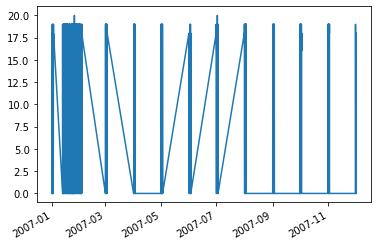

In [15]:
full_series.plot()

In [16]:
full_series.index

DatetimeIndex(['2007-01-01 02:30:00', '2007-01-01 02:31:00',
               '2007-01-01 02:32:00', '2007-01-01 02:33:00',
               '2007-01-01 02:34:00', '2007-01-01 02:35:00',
               '2007-01-01 02:36:00', '2007-01-01 02:37:00',
               '2007-01-01 02:38:00', '2007-01-01 02:39:00',
               ...
               '2007-11-02 15:52:00', '2007-11-02 15:53:00',
               '2007-11-02 15:54:00', '2007-11-02 15:55:00',
               '2007-11-02 15:56:00', '2007-11-02 15:57:00',
               '2007-11-02 15:58:00', '2007-11-02 15:59:00',
               '2007-11-02 16:00:00', '2007-11-02 16:01:00'],
              dtype='datetime64[ns]', length=62600, freq=None)

In [17]:
full_series.index.drop_duplicates()

DatetimeIndex(['2007-01-01 02:30:00', '2007-01-01 02:31:00',
               '2007-01-01 02:32:00', '2007-01-01 02:33:00',
               '2007-01-01 02:34:00', '2007-01-01 02:35:00',
               '2007-01-01 02:36:00', '2007-01-01 02:37:00',
               '2007-01-01 02:38:00', '2007-01-01 02:39:00',
               ...
               '2007-11-02 15:52:00', '2007-11-02 15:53:00',
               '2007-11-02 15:54:00', '2007-11-02 15:55:00',
               '2007-11-02 15:56:00', '2007-11-02 15:57:00',
               '2007-11-02 15:58:00', '2007-11-02 15:59:00',
               '2007-11-02 16:00:00', '2007-11-02 16:01:00'],
              dtype='datetime64[ns]', length=59850, freq=None)

In [18]:
full_series = full_series.loc[~full_series.index.duplicated(keep = 'first')]

In [19]:
full_series.index

DatetimeIndex(['2007-01-01 02:30:00', '2007-01-01 02:31:00',
               '2007-01-01 02:32:00', '2007-01-01 02:33:00',
               '2007-01-01 02:34:00', '2007-01-01 02:35:00',
               '2007-01-01 02:36:00', '2007-01-01 02:37:00',
               '2007-01-01 02:38:00', '2007-01-01 02:39:00',
               ...
               '2007-11-02 15:52:00', '2007-11-02 15:53:00',
               '2007-11-02 15:54:00', '2007-11-02 15:55:00',
               '2007-11-02 15:56:00', '2007-11-02 15:57:00',
               '2007-11-02 15:58:00', '2007-11-02 15:59:00',
               '2007-11-02 16:00:00', '2007-11-02 16:01:00'],
              dtype='datetime64[ns]', length=59850, freq=None)

In [20]:
print(full_series[5:6])

2007-01-01 02:35:00    0.0
Name: Sub_metering_3, dtype: float64


In [11]:
uniform_sample = uniform_sampler(x, 10)

In [12]:
print(uniform_sample)

2007-01-01 00:00:00    0.0
2007-01-01 00:00:00    0.0
2007-01-01 00:10:00    0.0
2007-01-01 00:20:00    0.0
2007-01-01 00:30:00    0.0
                      ... 
2008-12-31 23:16:00    0.0
2008-12-31 23:26:00    0.0
2008-12-31 23:36:00    0.0
2008-12-31 23:46:00    0.0
2008-12-31 23:56:00    0.0
Name: Sub_metering_3, Length: 104859, dtype: float64


In [17]:
eb_sample = empirical_bernstein(0.05,0.01,20,x)

In [18]:
print(eb_sample) 

2007-01-01 00:00:00     0.0
2008-01-14 19:08:00     0.0
2008-03-22 15:18:00     0.0
2008-03-31 23:51:00    18.0
2007-09-10 03:48:00     0.0
                       ... 
2007-01-30 17:49:00    18.0
2007-07-26 15:48:00     0.0
2007-10-11 21:53:00    17.0
2008-03-10 09:37:00    18.0
2008-10-21 13:49:00    28.0
Name: Sub_metering_3, Length: 9190, dtype: float64


In [19]:
eb_sample = eb_sample.sort_index()

In [20]:
eb_sample

2007-01-01 00:00:00     0.0
2007-01-01 02:36:00     0.0
2007-01-01 05:54:00     0.0
2007-01-01 08:49:00     0.0
2007-01-01 12:08:00     0.0
                       ... 
2008-12-31 20:28:00    17.0
2008-12-31 21:30:00     0.0
2008-12-31 23:12:00     0.0
2008-12-31 23:13:00     0.0
2008-12-31 23:36:00     0.0
Name: Sub_metering_3, Length: 9190, dtype: float64

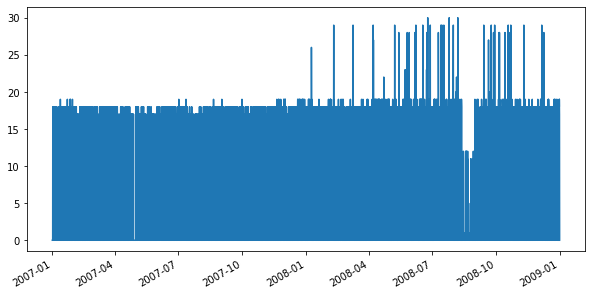

In [21]:
eb_sample.plot(figsize=(10, 5))

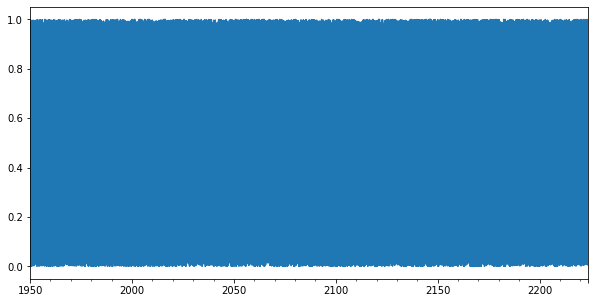

In [59]:
np.random.seed(1)

points = 100000
data = np.random.rand(points) # You can use other random functions to generate values with constraints
tidx = pd.date_range('1950-01-01', periods=points, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(data, index =tidx)
series.plot(figsize=(10, 5))

In [60]:
uniform_sample = uniform_sampler(series)

In [65]:
uniform_sample = uniform_sample.resample('D').mean()

In [66]:
uniform_sample.head(20)

1950-01-01    0.417022
1950-01-02         NaN
1950-01-03         NaN
1950-01-04         NaN
1950-01-05         NaN
1950-01-06    0.092339
1950-01-07         NaN
1950-01-08         NaN
1950-01-09         NaN
1950-01-10         NaN
1950-01-11    0.419195
1950-01-12         NaN
1950-01-13         NaN
1950-01-14         NaN
1950-01-15         NaN
1950-01-16    0.670468
1950-01-17         NaN
1950-01-18         NaN
1950-01-19         NaN
1950-01-20         NaN
Freq: D, dtype: float64

In [67]:
value = interpolation_query(uniform_sample, 9, method = 'linear')
value_quadratic = interpolation_query(uniform_sample, 4, method = 'quadratic')

In [68]:
print(value)
print(value_quadratic)

nan
nan


lag 0:  -0.007205660309202525
lag 1:  -0.0019183952434179891
lag 2:  0.0011692624424227748
lag 3:  0.0011924314773994354
lag 4:  -0.001917270284002118


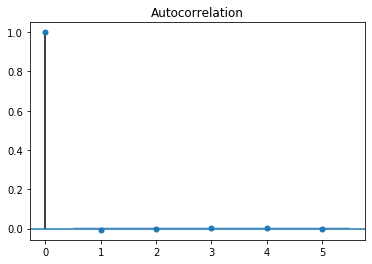

In [17]:
lags = correlation_query(series, number_of_lags = 5, print_lags = True, plot = True)

In [27]:
eb_sample = empirical_bernstein(0.05,0.01,1,series)

In [28]:
eb_sample.resample('D').mean()

1950-01-01    0.417022
1950-01-02         NaN
1950-01-03         NaN
1950-01-04         NaN
1950-01-05         NaN
                ...   
2223-09-30         NaN
2223-10-01         NaN
2223-10-02         NaN
2223-10-03         NaN
2223-10-04    0.631118
Freq: D, Length: 99988, dtype: float64

## Query comparison

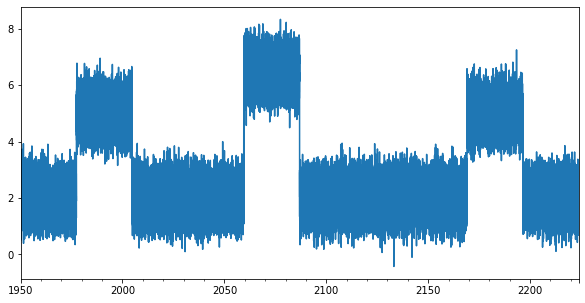

In [4]:
#Piecewise Stationary series

#Parameters
n = 100000
mu = 2
sigma = 0.5

#Gaussian distribution
np.random.seed(100)
x = np.random.normal(mu, sigma, n)

#Altered means
x[10000:20000] += 3
x[40000:50000] += 4.5
x[60000:70000] += 0
x[80000:90000] += 3

#plot
tidx = pd.date_range('1950-01-01', periods=n, freq='D') # freq='MS'set the frequency of date in months and start from day 1. You can use 'T' for minutes and so on
series = pd.Series(x, index =tidx)
series.plot(figsize=(10, 5))

In [15]:
#Baseline Subsamples
eb_sample = empirical_bernstein(0.05,0.01,3,series)
uniform_sample = uniform_sampler(series, 5)

In [16]:
#upscaled subsamples
eb_sample_upscaled = eb_sample.resample('D').mean()
uniform_sample_upscaled = uniform_sample.resample('D').mean()

In [17]:
uniform_sample_upscaled.head(20)

1950-01-01    1.125117
1950-01-02         NaN
1950-01-03         NaN
1950-01-04         NaN
1950-01-05         NaN
1950-01-06    2.257109
1950-01-07         NaN
1950-01-08         NaN
1950-01-09         NaN
1950-01-10         NaN
1950-01-11    1.770987
1950-01-12         NaN
1950-01-13         NaN
1950-01-14         NaN
1950-01-15         NaN
1950-01-16    1.947794
1950-01-17         NaN
1950-01-18         NaN
1950-01-19         NaN
1950-01-20         NaN
Freq: D, dtype: float64

In [18]:
#interpolation querry
#10
print('Interpolation for 10th value: \n')
print('Real value: ', series[10])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 10, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 10, method = 'linear'))
print('Online Sampler:', )
print('------------\n')

#17400
print('Interpolation for 17400 value: \n')
print('Real value: ', series[17401])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 17401, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 17401, method = 'linear'))
print('Online Sampler:', )
print('------------\n')

#1003

print('Interpolation for 1003 value: \n')
print('Real value: ', series[1003])
print('Empirical Bernstein: ', interpolation_query(eb_sample_upscaled, 1003, method = 'linear'))
print('Uniform sampler: ', interpolation_query(uniform_sample_upscaled, 1003, method = 'linear'))
print('Online Sampler:', )
print('------------\n')


Interpolation for 10th value: 

Real value:  1.770986507248688
Empirical Bernstein:  1.770986507248688
Uniform sampler:  1.770986507248688
Online Sampler:
------------

Interpolation for 17400 value: 

Real value:  5.147529836671587
Empirical Bernstein:  5.1509564727292005
Uniform sampler:  4.910361655171728
Online Sampler:
------------

Interpolation for 1003 value: 

Real value:  1.9178734829314086
Empirical Bernstein:  2.924264480432045
Uniform sampler:  1.782105532568902
Online Sampler:
------------



In [19]:
# Distance metrics for linear interpolation

print('Euclidean distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled))
print('Online Sampler: \n', )
print('------------ \n')

print('DTW distance: \n')
print('Empirical Bernstein: ', interpolation_distance(series, eb_sample_upscaled, distance = 'dtw'))
print('Uniform: ', interpolation_distance(series, uniform_sample_upscaled, distance = 'dtw'))
print('Online Sampler: \n', )
print('------------\n')

Euclidean distance: 

Empirical Bernstein:  207.03947470446448
Uniform:  178.60686394476375
Online Sampler: 

------------ 

DTW distance: 

Empirical Bernstein:  46153.82164185152
Uniform:  40637.68328494871
Online Sampler: 

------------



In [21]:
# Autocorrelation

print('Autocorrelation: \n')
print('Original time series: ')
correlation_query(series, number_of_lags = 10, print_lags = True, plot = False)
print('Empirical Bernstein: ')
correlation_query(eb_sample, number_of_lags = 10, print_lags = True, plot = False)
print('Uniform: ' )
correlation_query(uniform_sample, number_of_lags = 10, print_lags = True, plot = False)
print('Online Sampler: \n', )
print('------------ \n')

Autocorrelation: 

Original time series: 
lag 0:  0.9165781908920051
lag 1:  0.9163356767945378
lag 2:  0.916456229259552
lag 3:  0.9159109785164908
lag 4:  0.9160145043489284
lag 5:  0.9156005378224017
lag 6:  0.9158505883523945
lag 7:  0.9155048716888063
lag 8:  0.9155798800822517
lag 9:  0.9151567928977699
Empirical Bernstein: 
lag 0:  0.003427924434583126
lag 1:  -0.014911657481562809
lag 2:  -0.02004890017267406
lag 3:  0.035322317074204794
lag 4:  0.000886306304977263
lag 5:  0.028450172221066192
lag 6:  0.022495155352725373
lag 7:  -0.031077150287325297
lag 8:  0.0076905335739679915
lag 9:  0.009537426000761537
Uniform: 
lag 0:  0.9167974232665349
lag 1:  0.9155433843258257
lag 2:  0.9156776398915739
lag 3:  0.9143790106456892
lag 4:  0.9121730941285333
lag 5:  0.9140326034521267
lag 6:  0.9126690975388864
lag 7:  0.9111286488686366
lag 8:  0.9111079120093657
lag 9:  0.9102364427646076
Online Sampler: 

------------ 

